Выполнить ячейку Ctrl + Enter \\
Создать новую ячейку Ctrl + M and B \\
Передвинуть ячеку вверх Ctrl + M and K \\
Передвинуть ячеку вниз Ctrl + M and J \\
Прервать выполнение программы Ctrl + M and I \\
Посмотреть подсказки кода Ctrl+Space \\

# data.py

In [17]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def adjustData(img, mask, flag_multi_class, num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img, mask)



def trainGenerator(batch_size,train_path, image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)



def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img


def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = True,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item,as_gray = image_as_gray)
        img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr


def labelVisualize(num_class, color_dict, img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class, COLOR_DICT, item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i), img)


#model.py

In [25]:
!pip install tensorflow_addons
import numpy as np
import os
# Image processing in Python
import skimage.io as io
import skimage.transform as trans
import numpy as np


from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

def unet(pretrained_weights = None, input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    # AdamW
    model.compile(optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Adam
    # model.compile(optimizer = Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])


    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Google Drive

In [19]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#main.py

In [ ]:
# 06.06.22 - Cells - AdamW - Idk
import os
main_dir = "/content/drive/MyDrive"

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20, os.path.join(main_dir, "data_cells/membrane/train"),
                        "image", "label", data_gen_args, 
                        save_to_dir=os.path.join(main_dir, "data_cells/membrane/train/aug"))
model = unet()
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/weights/weightsAdamW_cells.hdf5", monitor="loss", verbose=1, save_best_only=True)
model.fit(myGenerator, steps_per_epoch=1000, epochs=5, callbacks=[model_checkpoint])
# Оно само сломалось, запаузило рантайм =(

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8729
Epoch 1: loss improved from inf to 0.30654, saving model to /content/drive/MyDrive/weights/weightsAdamW_cells.hdf5
1000/1000 [==============================] - 1268s 1s/step - loss: 0.3065 - accuracy: 0.8729
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9052
Epoch 2: loss improved from 0.30654 to 0.26190, saving model to /content/drive/MyDrive/weights/weightsAdamW_cells.hdf5
1000/1000 [==============================] - 1229s 1s/step - loss: 0.2619 - accuracy: 0.9052
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.9142
Epoch 3: loss improved from 0.26190 to 0.24826, saving model to /content/drive/MyDrive/weights/weightsAdamW_cells.hdf5
1000/1000 [==============================] - 1230s 1s/step - loss: 0.2483 - accuracy: 0.91

In [ ]:
# 05.06.22 - Cells - Adam - Idk
import os
main_dir = "/content/drive/MyDrive"

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20, os.path.join(main_dir, "data_cells/membrane/train"),
                        "image", "label", data_gen_args, 
                        save_to_dir=os.path.join(main_dir, "data_cells/membrane/train/aug"))
model = unet()
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/weights/weightsAdam_cells.hdf5", monitor="loss", verbose=1, save_best_only=True)
model.fit(myGenerator, steps_per_epoch=1000, epochs=5, callbacks=[model_checkpoint])

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8699
Epoch 1: loss improved from inf to 0.31163, saving model to /content/drive/MyDrive/weights/weightsAdam_cells.hdf5
1000/1000 [==============================] - 1649s 2s/step - loss: 0.3116 - accuracy: 0.8699
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.9049
Epoch 2: loss improved from 0.31163 to 0.26391, saving model to /content/drive/MyDrive/weights/weightsAdam_cells.hdf5
1000/1000 [==============================] - 1223s 1s/step - loss: 0.2639 - accuracy: 0.9049
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.9149
Epoch 3: loss improved from 0.26391 to 0.21006, saving model to /content/drive/MyDrive/weights/weightsAdam_cells.hdf5
1000/1000 [==============================] - 1218s 1s/step - loss: 0.2101 - accuracy: 0.9149


In [ ]:
# 04.06.22 - Liver - Success
import os
main_dir = "/content/drive/MyDrive"

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20, os.path.join(main_dir, "data_liver/liver/train"),
                        "image", "label", data_gen_args, 
                        save_to_dir=os.path.join(main_dir, "data_liver/liver/train/aug"))
model = unet()
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/weights/besttry5epochs_liver.hdf5", monitor="loss", verbose=1, save_best_only=True)
model.fit(myGenerator, steps_per_epoch=1000, epochs=5, callbacks=[model_checkpoint])

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9663
Epoch 1: loss improved from inf to 0.08230, saving model to /content/drive/MyDrive/weights/besttry5epochs_liver.hdf5
1000/1000 [==============================] - 1975s 2s/step - loss: 0.0823 - accuracy: 0.9663
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9902
Epoch 2: loss improved from 0.08230 to 0.02429, saving model to /content/drive/MyDrive/weights/besttry5epochs_liver.hdf5
1000/1000 [==============================] - 1156s 1s/step - loss: 0.0243 - accuracy: 0.9902
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0156 - accuracy: 0.9936
Epoch 3: loss improved from 0.02429 to 0.01562, saving model to /content/drive/MyDrive/weights/besttry5epochs_liver.hdf5
1000/1000 [==============================] - 1151s 1s/step - loss: 0.0156 - accuracy

In [ ]:
model.save_weights("/content/drive/MyDrive/weights/final_besttry5epochs_liver.hdf5")

In [ ]:
import os
main_dir = "/content/drive/MyDrive"

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20, os.path.join(main_dir, "data_liver/membrane/train"),
                        "image", "label", data_gen_args, 
                        save_to_dir=os.path.join(main_dir, "data_liver/membrane/train/aug"))
model = unet()
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/data_liver/weight5epochs.hdf5", monitor="loss", verbose=1, save_best_only=True)
model.fit(myGenerator, steps_per_epoch=1000, epochs=1, callbacks=[model_checkpoint])
model.save_weights("/content/drive/MyDrive/data_liver/final_weight5epochs.hdf5")

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.9066
Epoch 1: loss improved from inf to 0.69219, saving model to /content/drive/MyDrive/data_liver/weight5epochs.hdf5
1000/1000 [==============================] - 1158s 1s/step - loss: 0.6922 - accuracy: 0.9066
Epoch 2/5
1000/1000 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.9110
Epoch 2: loss improved from 0.69219 to 0.68705, saving model to /content/drive/MyDrive/data_liver/weight5epochs.hdf5
1000/1000 [==============================] - 1138s 1s/step - loss: 0.6870 - accuracy: 0.9110
Epoch 3/5
1000/1000 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.9110
Epoch 3: loss improved from 0.68705 to 0.68301, saving model to /content/drive/MyDrive/data_liver/weight5epochs.hdf5
1000/1000 [==============================] - 1138s 1s/step - loss: 0.6830 - accuracy: 0.9110
Epo

In [ ]:
import os
main_dir = "/content/drive/MyDrive"

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20, os.path.join(main_dir, "data_liver/membrane/train"),
                        "image", "label", data_gen_args, 
                        save_to_dir=os.path.join(main_dir, "data_liver/membrane/train/aug"))
model = unet(pretrained_weights=os.path.join(main_dir, "data_liver/weight5epochs.hdf5"))
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/data_liver/weight5epochs.hdf5", monitor="loss", verbose=1, save_best_only=True)
model.fit(myGenerator, steps_per_epoch=1000, epochs=1, callbacks=[model_checkpoint])
model.save_weights("/content/drive/MyDrive/data_liver/final_weight5epochs.hdf5")

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
1000/1000 [==============================] - ETA: 0s - loss: 0.6710 - accuracy: 0.9111
Epoch 1: loss improved from inf to 0.67103, saving model to /content/drive/MyDrive/data_liver/weight5epochs.hdf5
1000/1000 [==============================] - 1137s 1s/step - loss: 0.6710 - accuracy: 0.9111


In [ ]:
model.save_weights("/content/drive/MyDrive/data_cells/finalweight5epochs.hdf5")

In [ ]:
import os
main_dir = "/content/drive/MyDrive"

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20, os.path.join(main_dir, "data_liver/membrane/train"),
                        "image", "label", data_gen_args, 
                        save_to_dir=os.path.join(main_dir, "data_liver/membrane/train/aug"))
model = unet()
model_checkpoint = ModelCheckpoint("/content/drive/MyDrive/data_liver/weight10epochs.hdf5", monitor="loss", verbose=1, save_best_only=True)
model.fit(myGenerator, steps_per_epoch=1000, epochs=10, callbacks=[model_checkpoint])

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.9298
Epoch 1: loss improved from inf to 0.34298, saving model to /content/drive/MyDrive/data_liver/weight10epochs.hdf5
1000/1000 [==============================] - 1231s 1s/step - loss: 0.3430 - accuracy: 0.9298
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9855
Epoch 2: loss improved from 0.34298 to 0.03378, saving model to /content/drive/MyDrive/data_liver/weight10epochs.hdf5
1000/1000 [==============================] - 1227s 1s/step - loss: 0.0338 - accuracy: 0.9855
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9919
Epoch 3: loss improved from 0.03378 to 0.01935, saving model to /content/drive/MyDrive/data_liver/weight10epochs.hdf5
1000/1000 [==============================] - 1230s 1s/step - loss: 0.0194 - accuracy: 0.99

UnknownError: ignored

Test results

In [ ]:
main_dir = "/content/drive/MyDrive"
model = unet(pretrained_weights=os.path.join(main_dir, "data_liver/savetest.hdf5"))
Generator = testGenerator(os.path.join(main_dir, "data_liver/membrane/test"))
results = model.predict(Generator, 30, verbose=1)
saveResult("/content/drive/MyDrive/data_liver/membrane/test", results)

30/30 [==============================] - 55s 2s/step


Глава про Google Colab

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


# Загрузка локальных данных

In [ ]:
import matplotlib.pyplot as plt
import os

'''
Фукнция переноса скаченных файлов в новую директорию
Функция удаления всех изображений из директории
'''

def fetch_images(sr_path, ds_path):
  for i in range(30):
    try:
      image = plt.imread(os.path.join(sr_path, "{}.png".format(i)))
      plt.imsave(os.path.join(ds_path, "{}.png".format(i)), image)
    except:
        print("Не удалось перенести файл {}.png".format(i))
  print("Fine!")

def del_images(sr_path):
  for i in range(30):
    try:
      image = os.remove(os.path.join(sr_path, "{}.png".format(i)))
    except:
        print("Не удалось удалить файл {}.png".format(i))
  print("Fine!")

def create_folders_1():
  data = os.mkdir("data")
  membrane = os.mkdir(os.path.join("/" + data, "membrane"))
  train = os.mkdir(os.path.join(membrane, "train"))
  image = os.mkdir(os.path.join(train, "image"))
  label = os.mkdir(os.path.join(train, "label"))
  print("Fine!")


In [ ]:
# fetch_images("/content", "/data/membrane/train/image")
fetch_images("/content", "/data/membrane/train/label") 
del_images("/content")

Fine!
Fine!


In [ ]:
from google.colab import files
files.download("unet_membrane.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

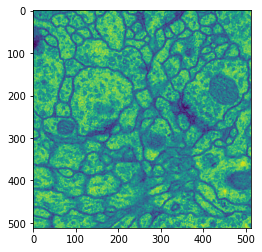

In [ ]:
import matplotlib.pyplot as plt
image = plt.imread(os.path.join("/content", "{}.png".format(0)))
plt.imsave(os.path.join("/data/membrane/train", "{}.png".format(0)), image)
plt.imshow(image)

#Generating training data

In [ ]:
import random
import time
'''
Генератор случайной последовательности уникальных натуральных чисел

count - соличество чисел
limit - предел максимального числа
'''
def get_unique_random_data(count, limit):
    if count > limit:
        print("Count > limit")
        exit()
    random.seed(time.time())
    digit = random.randint(0, limit)
    rand_arr = []
    i = 0
    while count - i != 0:
        if digit not in rand_arr:
            rand_arr.append(digit)
            i += 1
            digit = random.randint(0, limit)
        else:
            digit = random.randint(0, limit)
    return rand_arr

In [ ]:
from pydicom import dcmread
import skimage.io as io

'''
Получение из 3-х различных источников данных своих 30-ти данных для обучения
'''

save_path_1 = "E:\dev\Part_2\Data\CT_data_batch1/data1/train/image"
save_path_2 = "E:\dev\Part_2\Data\CT_data_batch1/data1/train/label"
data_used = [1, 5, 6]
k = 0
f = open("E:\dev\Part_2\Data\CT_data_batch1/data1/train/info.txt", "w")
for i in data_used:
    rand_arr = get_unique_random_data(10, 85)
    for j in rand_arr:
        if j < 10:
            print("E:\dev\Part_2\Data\CT_data_batch1/{}\Ground/liver_GT_0{}".format(i, j))
            ds = dcmread("E:\dev\Part_2\Data\CT_data_batch1/{}\DICOM_anon\i000{},0000b.dcm".format(i, j))
            label = io.imread("E:\dev\Part_2\Data\CT_data_batch1/{}\Ground/liver_GT_00{}.png".format(i, j))
            print("{}\DICOM_anon\i000{},0000b.dcm data used".format(i, j))
            f.write("{}\DICOM_anon\i000{},0000b.dcm data used \n".format(i, j))
        else:
            print("E:\dev\Part_2\Data\CT_data_batch1/{}\Ground/liver_GT_0{}".format(i, j))
            ds = dcmread("E:\dev\Part_2\Data\CT_data_batch1/{}\DICOM_anon\i00{},0000b.dcm".format(i, j))
            label = io.imread("E:\dev\Part_2\Data\CT_data_batch1/{}\Ground/liver_GT_0{}.png".format(i, j))
            print("{}\DICOM_anon\i00{},0000b.dcm data used".format(i, j))
            f.write("{}\DICOM_anon\i00{},0000b.dcm data used \n".format(i, j))
        arr = ds.pixel_array
        arr = arr / 255
        io.imsave(os.path.join(save_path_1,"{}.png".format(k)), arr)
        io.imsave(os.path.join(save_path_2, "{}.png".format(k)), label)
        k += 1
f.close()

In [ ]:
'''
Что-то тоже из того же разряда (уже не помню), запускать с осторожностью
'''

save_path_3 = "E:\dev\Part_2\Data\CT_data_batch1/data1/test"
data_used = [2, 5, 8]
k = 0
for i in data_used:
    rand_arr = get_unique_random_data(10, 85)
    for j in rand_arr:
        if j < 10:
            ds = dcmread("E:\dev\Part_2\Data\CT_data_batch1/{}\DICOM_anon\i000{},0000b.dcm".format(i, j))
        else:
            ds = dcmread("E:\dev\Part_2\Data\CT_data_batch1/{}\DICOM_anon\i00{},0000b.dcm".format(i, j))
        arr = ds.pixel_array
        arr = arr / 255
        io.imsave(os.path.join(save_path_3,"{}.png".format(k)), arr)
        k += 1

In [ ]:
my_path = 'E:/dev/Part_2/UNET/unet/data/membrane/train'
!cd E:/dev/Part_2/UNET/unet/data/membrane/train

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2, my_path, 'image', 'label', data_gen_args, save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene, steps_per_epoch=2000, epochs=2, callbacks=[model_checkpoint])

In [ ]:
# FOR LOCAL USING
import os
main_dir = "E:/dev/Part_2/UNET/unet"

'''
Получение вердикта модели
'''

testGene = testGenerator(os.path.join(main_dir, "data/membrane/test"))
model = unet()
model.load_weights(os.path.join(main_dir, "unet_membrane.hdf5"))
results = model.predict(testGene, 30, verbose=1)
saveResult(os.path.join(main_dir, "data/membrane/test"), results)

In [ ]:
import tensorflow as tf
saver = tf.train.Saver()
save_path = saver.save(session, "data_/dm.ckpt")
print('done saving at',save_path)

AttributeError: ignored

In [ ]:
from google.colab import files
files.upload()